# Reports
1. Inputs: data raw from kaggle and business problems
2. Outputs: analisys about business hypothesis

# 1.0 Imports

###### 1.1 Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import pickle

import time
from IPython.display import Image

tempo_agora = time.time() # Contabilizando o tempo de processamento do projeto

###### 1.2 Loading dataset

In [2]:
# reading csv
df = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\bank_churn_predict\\bank_churn_predict\\data\\raw\\churn.csv')
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


###### 1.3 Helper functions

In [3]:
# identificando outliers
def busca_outliers(df, series):
    q1 = np.percentile(df[series], 25)
    q3 = np.percentile(df[series], 75)
    distancia = q3 - q1
    salto = distancia * 1.5
    li = q1 - salto
    ls = q3 + salto
    indices = df[(df[series]<li)|(df[series]>ls)].index
#     print(f'O limite inferior é: {li}\nO limite superior é: {ls}\nHá {len(indices)} outliers')
    return indices, li, ls

# 2.0 Data Description

## 2.1 General Analysis

##### 2.1.1 Main insights:

###### Exited
1. Desbalanceado, por volta de 20% de churn
2. Correlação fraca com Age e muito fraca com as demais

###### NumOfProducts
1. Clientes com 3 ou 4 produtos têm maior probabilidade de churn, com 80% e 100% de churn respectivamente.
2. Correlação fraca negativa com Balance
3. 95% dos clientes possuem 1 ou 2 produtos

###### HasCrCard
1. 70% dos clientes possuem cartão de crédito
2. Aparentemente não ajuda a modelar o fenômeno
3. Correlações muito fracas

###### IsActiveMember
1. A quantidade de clientes ativos e inativos está equilibrada
2. Membros ativos são 47% menos propensos ao churn
3. Correlações muito fracas

###### Geography
1. Mais de 50% dos clientes está na França
2. Clientes da Germany têm maior probabilidade de churn
3. Correlações muito fracas

###### Gender
1. 54% dos clientes são homens
2. Mulheres têm 34% de chance maior de churn
3. Correlações muito fracas

###### CreditScore
1. Não há faixas de CreditScore mais suscetíveis ao churn
2. Correlações muito fracas
3. Há um teto máximo de score, distribuição semelhante a uma Poisson
4. Outliers somente no início da distribuição

###### Age
1. Idade mínima de 18 anos, máxima de 92, aparentemente sem erros de input
2. Média de idade de clientes em churn é de 45, já os em não churn é de 37
3. Correlação fraca com Exited
4. Cauda direita mais pesada
5. 359 outliers pelo método de Tukey

###### Balance
1. Balance com valor máximo bastante mais alto do que o terceiro quartil, indicando outliers. Com primeiro quartil com cliantes com valor zerado na conta, o que sugere que haja uma quantidade grande de contas com zero de saldo.
2. Clientes com saldo zerado na conta tem probabilidade relativamente menor de churn
3. Excluindo-se as contas de valores de Balance zerados, resta uma curva aparentemente normal com média em 12000
3. Correlação fraca com NumOfProducts
4. 36% das contas bancárias estão zeradas
5. Excluindo-se as contas com Balance igual a zero, pelo método de Tukey há 73 outliers

###### EstimatedSalary
1. Aparentemente não ajuda a modelar o fenômeno
2. Correlações muito fracas
3. Apresenta uma contagem bastante contínua em todo o range da variância da feature, semelhante a variáveis categóricas

###### Tenure
1. Aparentemente não ajuda a modelar o fenômeno
2. Correlações muito fracas
3. Apesar das médias de churn por categoria serem relativamente diferentes, os desvios padrões colocam todas as categorias em um mesmo patamar

##### 2.1.2 Looking dataset

In [4]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


##### 2.1.3 Data dimensions

In [5]:
print(f'O dataset possui: {df.shape[0]} linhas')
print(f'O dataset possui: {df.shape[1]} colunas')

O dataset possui: 10000 linhas
O dataset possui: 14 colunas


##### 2.1.4 Datatypes

In [6]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

##### 2.1.5 Changing interesting datatypes

In [7]:
geography_le = LabelEncoder()
geography_le = geography_le.fit(df['Geography'])
df['Geography_enc'] = geography_le.transform(df['Geography'])
gender_le = LabelEncoder()
gender_le = gender_le.fit(df['Gender'])
df['Gender_enc'] = gender_le.transform(df['Gender'])

##### 2.1.7 Cheking NaN values

In [8]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
Geography_enc      0
Gender_enc         0
dtype: int64

## 2.2 Descriptive Statistical

### 2.2.1 Classifying Attributes

In [9]:
cat_attributes = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Tenure', 'Gender', 'Geography']
num_attributes = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

### 2.2.2 Numerical Attributes

In [10]:
# Central tendency
ct1 = pd.DataFrame(df[num_attributes].apply(np.mean)).T
ct2 = pd.DataFrame(df[num_attributes].apply(np.median)).T

# Dispersion
d1 = pd.DataFrame(df[num_attributes].apply(np.std)).T
d2 = pd.DataFrame(df[num_attributes].apply(min)).T
d3 = pd.DataFrame(df[num_attributes].apply(max)).T
d4 = pd.DataFrame(df[num_attributes].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df[num_attributes].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df[num_attributes].apply(lambda x: x.kurtosis())).T

# Concat
temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
CreditScore,350.00,850.00,500.00,650.528800,652.000,96.648466,-0.071607,-0.425726
Age,18.00,92.00,74.00,38.921800,37.000,10.487282,1.011320,1.395347
Balance,0.00,250898.09,250898.09,76485.889288,97198.540,62394.285254,-0.141109,-1.489412
EstimatedSalary,11.58,199992.48,199980.90,100090.239881,100193.915,57507.617221,0.002085,-1.181518


1. CreditScore - média e mediana próximas, o que indica que os dados estão centralizados na média, a skew é baixa e negativa, o que reforça que os dados estejam centralizados na média com uma cauda esquerda levemente maior, kurtosis pouco negativo, o que sugere uma distribuição mais plana do que uma distribuição normal com mesma média e desvio padrão.
2. Age - somente maiores de 18 anos, média e mediana levemente deslocados (10%), skew baixa e positiva, indicando que os dados estão centralizados na média com uma cauda direita levemente maior, kurtosis baixa, características de uma NORMAL
3. Balance - mínimo em zero, média e mediana bastante deslocados, desvio padrão bastante alto, skew baixa, o que sugere uma distribuição centralizada na média apesar da média e mediana diferirem, kurtosis negativa, o que sugere uma distribuição mais plana.
4. EstimatedSalary - média e mediana próximas, desvio padrão bastante alto, skew centralizado na média, kurtosis baixa, distribuição mais plana do que uma normal.

### 2.2.3 Categorical Attributes

In [11]:
df[cat_attributes].apply(lambda x: x.nunique())

NumOfProducts      4
HasCrCard          2
IsActiveMember     2
Tenure            11
Gender             2
Geography          3
dtype: int64

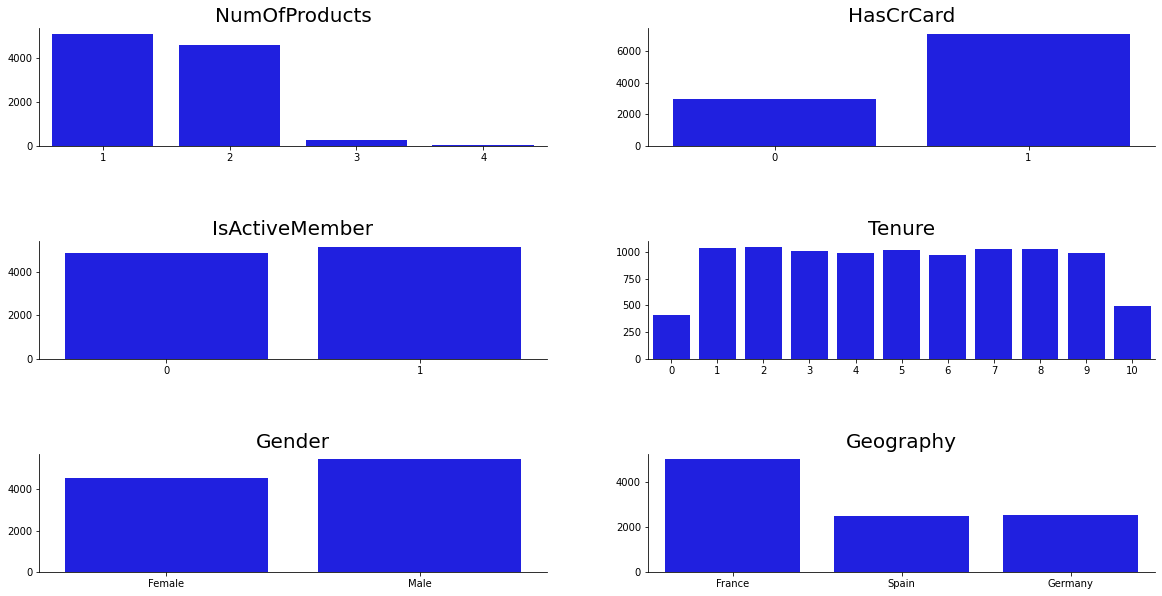

In [12]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.8)

plt.subplot(3, 2, 1)
sns.countplot(data=df, x='NumOfProducts', color='b')
sns.despine()
plt.title('NumOfProducts', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(3, 2, 2)
sns.countplot(data=df, x='HasCrCard', color='b')
sns.despine()
plt.title('HasCrCard', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(3, 2, 3)
sns.countplot(data=df, x='IsActiveMember', color='b')
sns.despine()
plt.title('IsActiveMember', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(3, 2, 4)
sns.countplot(data=df, x='Tenure', color='b')
sns.despine()
plt.title('Tenure', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(3, 2, 5)
sns.countplot(data=df, x='Gender', color='b')
sns.despine()
plt.title('Gender', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(3, 2, 6)
sns.countplot(data=df, x='Geography', color='b')
sns.despine()
plt.title('Geography', fontsize=20)
plt.xlabel('')
plt.ylabel('');

1. Maior parte dos clientes com 1 ou 2 produtos
2. Clientes com cartão de crédito são maioria]
3. Clientes na França são maioria

# 3.0 Feature Engineering

###### 3.1 tenure_exite_mean

In [13]:
map_tenure_exited_mean = df.groupby('Tenure').agg({'Exited':'mean'}).to_dict()['Exited']

In [14]:
df['tenure_exite_mean'] = df['Tenure'].map(map_tenure_exited_mean)

# 4.0 Exploratory Data Analysis

## 4.1 Business Hypothesis

### 4.1.1 Hypothesis Mindmap

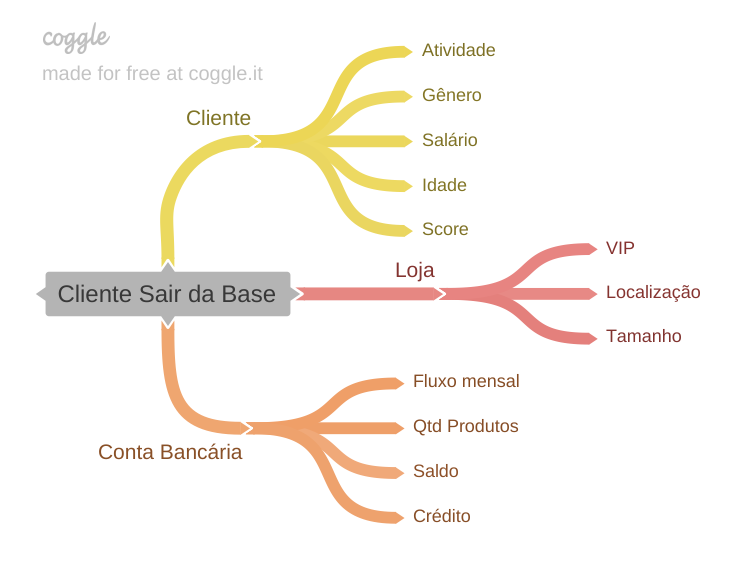

In [15]:
Image('..\\img\\mindmap.png')

### 4.1.2 Creating Hypothesis

###### Clientes:
1. Clientes mais ativos deveriam fazer menos churn.
2. Mulheres deveriam fazer menos churn.
3. Clientes com salários maiores deveriam fazer mais churn.
4. Clientes mais velhos deveriam fazer menos churn.
5. Clientes com melhores scores deveriam fazer mais churn

###### Conta Bancária:
1. Clientes com contas bancárias com maiores movimentações mensais deveriam fazer menos churn.
2. Clientes que adquirem mais produtos deveriam fazer menos churn.
3. Clientes com saldos bancários maiores deveriam fazer menos churn.
4. Clientes com cartão de crédito deveriam fazer menos churn.

###### Loja:
1. Lojas especiais VIPs deveriam ter menos churn.
2. Lojas melhor localizadas deveriam ter menos churn.
3. Lojas maiores deveriam ter menos churn.
4. Lojas localizadas em países com melhores PIB's deveriam vender mais.

###### Lista Final de Hipóteses:
As hipóteses em negrito foram selecionadas e serão estudadas primeiro. O principal critério para selecionar as possíveis hipóteses foi a disponibilidade de features que possibilitem os estudos.

1. Clientes mais ativos deveriam fazer menos churn.
2. Mulheres deveriam fazer menos churn.
3. Clientes com salários maiores deveriam fazer mais churn.
4. Clientes mais velhos deveriam fazer menos churn.
5. Clientes com melhores scores deveriam fazer mais churn
6. Clientes com contas bancárias com maiores movimentações mensais deveriam fazer menos churn.
7. Clientes que adquirem mais produtos deveriam fazer menos churn.
8. Clientes com saldos bancários maiores deveriam fazer menos churn.
9. Clientes com cartão de crédito deveriam fazer menos churn.

## 4.2 Univariate Analysis

### 4.2.1 Response Variable

Média de churn: 20.37%


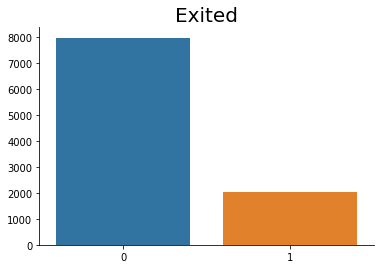

In [16]:
sns.countplot(data=df, x='Exited')
sns.despine()
plt.title('Exited', fontsize=20)
plt.xlabel('')
plt.ylabel('')
print(f"Média de churn: {round(df['Exited'].mean()*100, 2)}%")

### 4.2.2 Numerical Variables

In [17]:
num_attributes

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

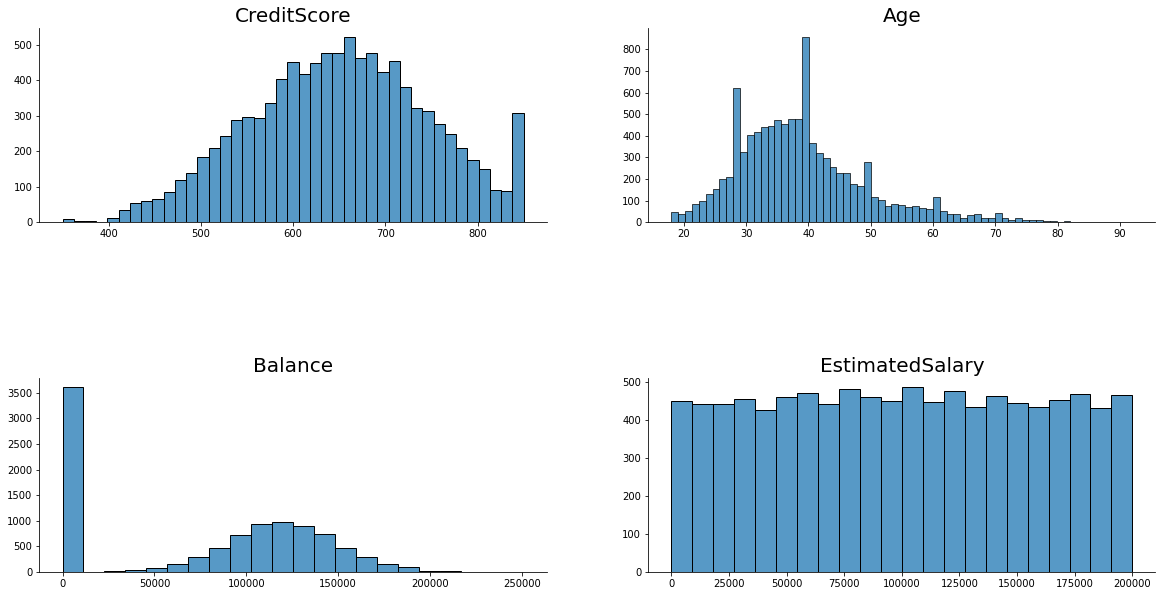

In [18]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.8)

plt.subplot(2, 2, 1)
indices, li, ls = busca_outliers(df, 'CreditScore')
temp = df.loc[indices]
sns.histplot(data=df, x='CreditScore')
sns.despine()
plt.title('CreditScore', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
indices, li, ls = busca_outliers(df, 'Age')
temp = df.loc[indices]
sns.histplot(data=df, x='Age')
sns.despine()
plt.title('Age', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
indices, li, ls = busca_outliers(df, 'Balance')
temp = df.loc[indices]
sns.histplot(data=df, x='Balance')
sns.despine()
plt.title('Balance', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
indices, li, ls = busca_outliers(df, 'EstimatedSalary')
temp = df.loc[indices]
sns.histplot(data=df, x='EstimatedSalary')
sns.despine()
plt.title('EstimatedSalary', fontsize=20)
plt.xlabel('')
plt.ylabel('');

1. Muitas contas zeradas
2. Salário estimado com uma distribuição totalmente plana

### 4.2.3 Categorical Variables

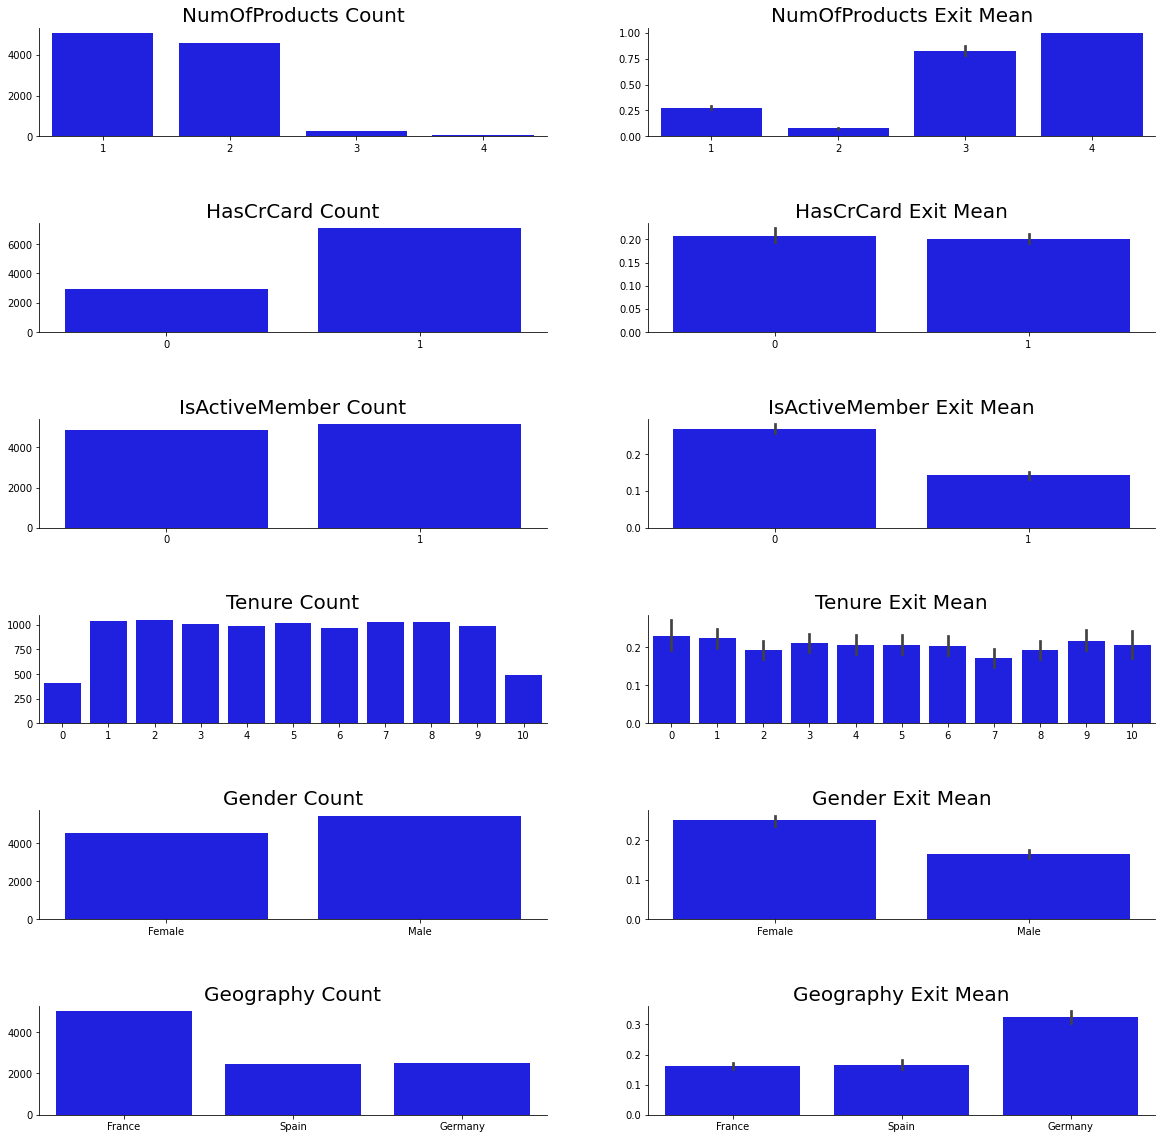

In [19]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.8)

plt.subplot(6, 2, 1)
sns.countplot(data=df, x='NumOfProducts', color='b')
sns.despine()
plt.title('NumOfProducts Count', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 2)
sns.barplot(data=df, x='NumOfProducts', y='Exited', color='b')
sns.despine()
plt.title('NumOfProducts Exit Mean', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 3)
sns.countplot(data=df, x='HasCrCard', color='b')
sns.despine()
plt.title('HasCrCard Count', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 4)
sns.barplot(data=df, x='HasCrCard', y='Exited', color='b')
sns.despine()
plt.title('HasCrCard Exit Mean', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 5)
sns.countplot(data=df, x='IsActiveMember', color='b')
sns.despine()
plt.title('IsActiveMember Count', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 6)
sns.barplot(data=df, x='IsActiveMember', y='Exited', color='b')
sns.despine()
plt.title('IsActiveMember Exit Mean', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 7)
sns.countplot(data=df, x='Tenure', color='b')
sns.despine()
plt.title('Tenure Count', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 8)
sns.barplot(data=df, x='Tenure', y='Exited', color='b')
sns.despine()
plt.title('Tenure Exit Mean', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 9)
sns.countplot(data=df, x='Gender', color='b')
sns.despine()
plt.title('Gender Count', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 10)
sns.barplot(data=df, x='Gender', y='Exited', color='b')
sns.despine()
plt.title('Gender Exit Mean', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 11)
sns.countplot(data=df, x='Geography', color='b')
sns.despine()
plt.title('Geography Count', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 12)
sns.barplot(data=df, x='Geography', y='Exited', color='b')
sns.despine()
plt.title('Geography Exit Mean', fontsize=20)
plt.xlabel('')
plt.ylabel('');

###### 1. Clientes mais ativos deveriam fazer menos churn.
Hipótese validada, clientes mais ativos fazem menos churn
###### 2. Mulheres deveriam fazer menos churn.
Hipótese refutada, mulheres fazem mais churn
###### 7. Clientes que adquirem mais produtos deveriam fazer menos churn.
Hipótese refutada, clientes que adquirirem mais produtos fazem mais churn
###### 9. Clientes com cartão de crédito deveriam fazer menos churn.
Hipótese refutada, cartão de crédito aparentemente é indiferente para o churn

## 4.3 Bivariate Analysis

###### 4.3.1 Clientes com salários maiores deveriam fazer mais churn.

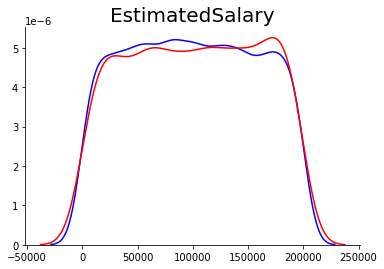

In [20]:
sns.kdeplot(data=df.loc[df['Exited']==0], x='EstimatedSalary', color='b')
sns.kdeplot(data=df.loc[df['Exited']==1], x='EstimatedSalary', color='r')
sns.despine()
plt.title('EstimatedSalary', fontsize=20)
plt.xlabel('')
plt.ylabel('');

Hipótese refutada, salário aparentemente não influencia no churn

###### 4.3.2. Clientes mais velhos deveriam fazer menos churn.

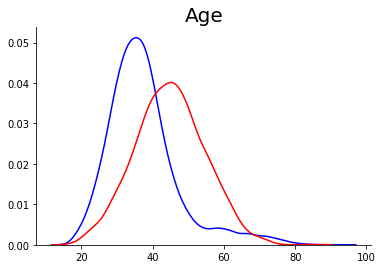

In [21]:
sns.kdeplot(data=df.loc[df['Exited']==0], x='Age', color='b')
sns.kdeplot(data=df.loc[df['Exited']==1], x='Age', color='r')
sns.despine()
plt.title('Age', fontsize=20)
plt.xlabel('')
plt.ylabel('');

In [22]:
print(f"Média de clientes que permanecem na base: {int(df.loc[df['Exited']==0, 'Age'].mean())}")
print(f"Média de clientes em churn: {int(df.loc[df['Exited']==1, 'Age'].mean())}")

Média de clientes que permanecem na base: 37
Média de clientes em churn: 44


Hipótese refutada, clientes mais velhos fazem mais churn

###### 4.3.3. Clientes com melhores scores deveriam fazer mais churn

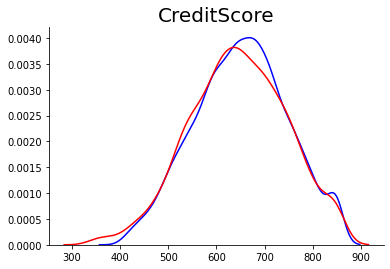

In [23]:
sns.kdeplot(data=df.loc[df['Exited']==0], x='CreditScore', color='b')
sns.kdeplot(data=df.loc[df['Exited']==1], x='CreditScore', color='r')
sns.despine()
plt.title('CreditScore', fontsize=20)
plt.xlabel('')
plt.ylabel('');

Hipótese refutada, score aparentemente não influencia no churn

###### 4.3.4. Clientes com saldos bancários maiores deveriam fazer menos churn.

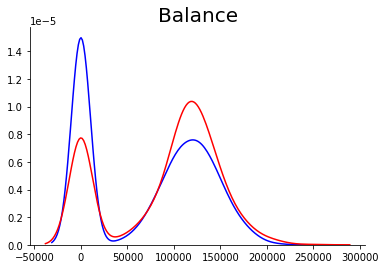

In [24]:
sns.kdeplot(data=df.loc[df['Exited']==0], x='Balance', color='b')
sns.kdeplot(data=df.loc[df['Exited']==1], x='Balance', color='r')
sns.despine()
plt.title('Balance', fontsize=20)
plt.xlabel('')
plt.ylabel('');

Hipótese refutada, clientes com mais dinheiro na conta fazem mais churn.

## 4.4 Multivariate Analysis

# 6.0 Exporting Data

###### 6.1 Dataframe

In [25]:
pickle.dump(df, open('D://My Drive//Pessoal//Projetos//bank_churn_predict//bank_churn_predict//data//interim//df_to_data_preparation.pkl', 'wb'))

###### 6.2 Features

In [26]:
# Tenure_Exited_Mean
pickle.dump(map_tenure_exited_mean, open('D://My Drive//Pessoal//Projetos//bank_churn_predict//deploy//transformers//map_tenure_exited_mean.pkl', 'wb'))
pickle.dump(map_tenure_exited_mean, open('D://My Drive//Pessoal//Projetos//bank_churn_predict//bank_churn_predict//src//features//map_tenure_exited_mean.pkl', 'wb'))

In [27]:
# Geography_enc
pickle.dump(geography_le, open('D://My Drive//Pessoal//Projetos//bank_churn_predict//deploy//transformers//geography_le.pkl', 'wb'))
pickle.dump(geography_le, open('D://My Drive//Pessoal//Projetos//bank_churn_predict//bank_churn_predict//src//features//geography_le.pkl', 'wb'))

# Gender_enc
pickle.dump(gender_le, open('D://My Drive//Pessoal//Projetos//bank_churn_predict//deploy//transformers//gender_le.pkl', 'wb'))
pickle.dump(gender_le, open('D://My Drive//Pessoal//Projetos//bank_churn_predict//bank_churn_predict//src//features//gender_le.pkl', 'wb'))

# Time

In [28]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-tempo_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 0 minutos
